# 1. Importing Modules and Data

In [1]:
# Standard Libraries
import os
import random

# Data Handling and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import VGG16, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D

# TensorFlow and Keras for Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, optimizers, Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNet
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense

In [ ]:
# The images are in a folder named 'shapes/training'
train_data = os.path.join('imgs/train')
test_data = os.path.join('imgs/test/')
driver_imgs_list = pd.read_csv(os.path.join('driver_imgs_list.csv'))
sample_submission = pd.read_csv(os.path.join('sample_submission.csv'))

# All images are 128x128 pixels
img_size = (128,128)

# The folder contains a subfolder for each class of shape
classes = sorted(os.listdir(train_data))

classes_names = {'c0': 'safe driving',
'c1': 'texting - right',
'c2': 'talking on the phone - right',
'c3': 'texting - left',
'c4': 'talking on the phone - left',
'c5': 'operating the radio',
'c6': 'drinking',
'c7': 'reaching behind',
'c8': 'hair and makeup',
'c9': 'talking to passenger'}

print(classes_names)

{'c0': 'safe driving', 'c1': 'texting - right', 'c2': 'talking on the phone - right', 'c3': 'texting - left', 'c4': 'talking on the phone - left', 'c5': 'operating the radio', 'c6': 'drinking', 'c7': 'reaching behind', 'c8': 'hair and makeup', 'c9': 'talking to passenger'}


# 2. Data Exploration

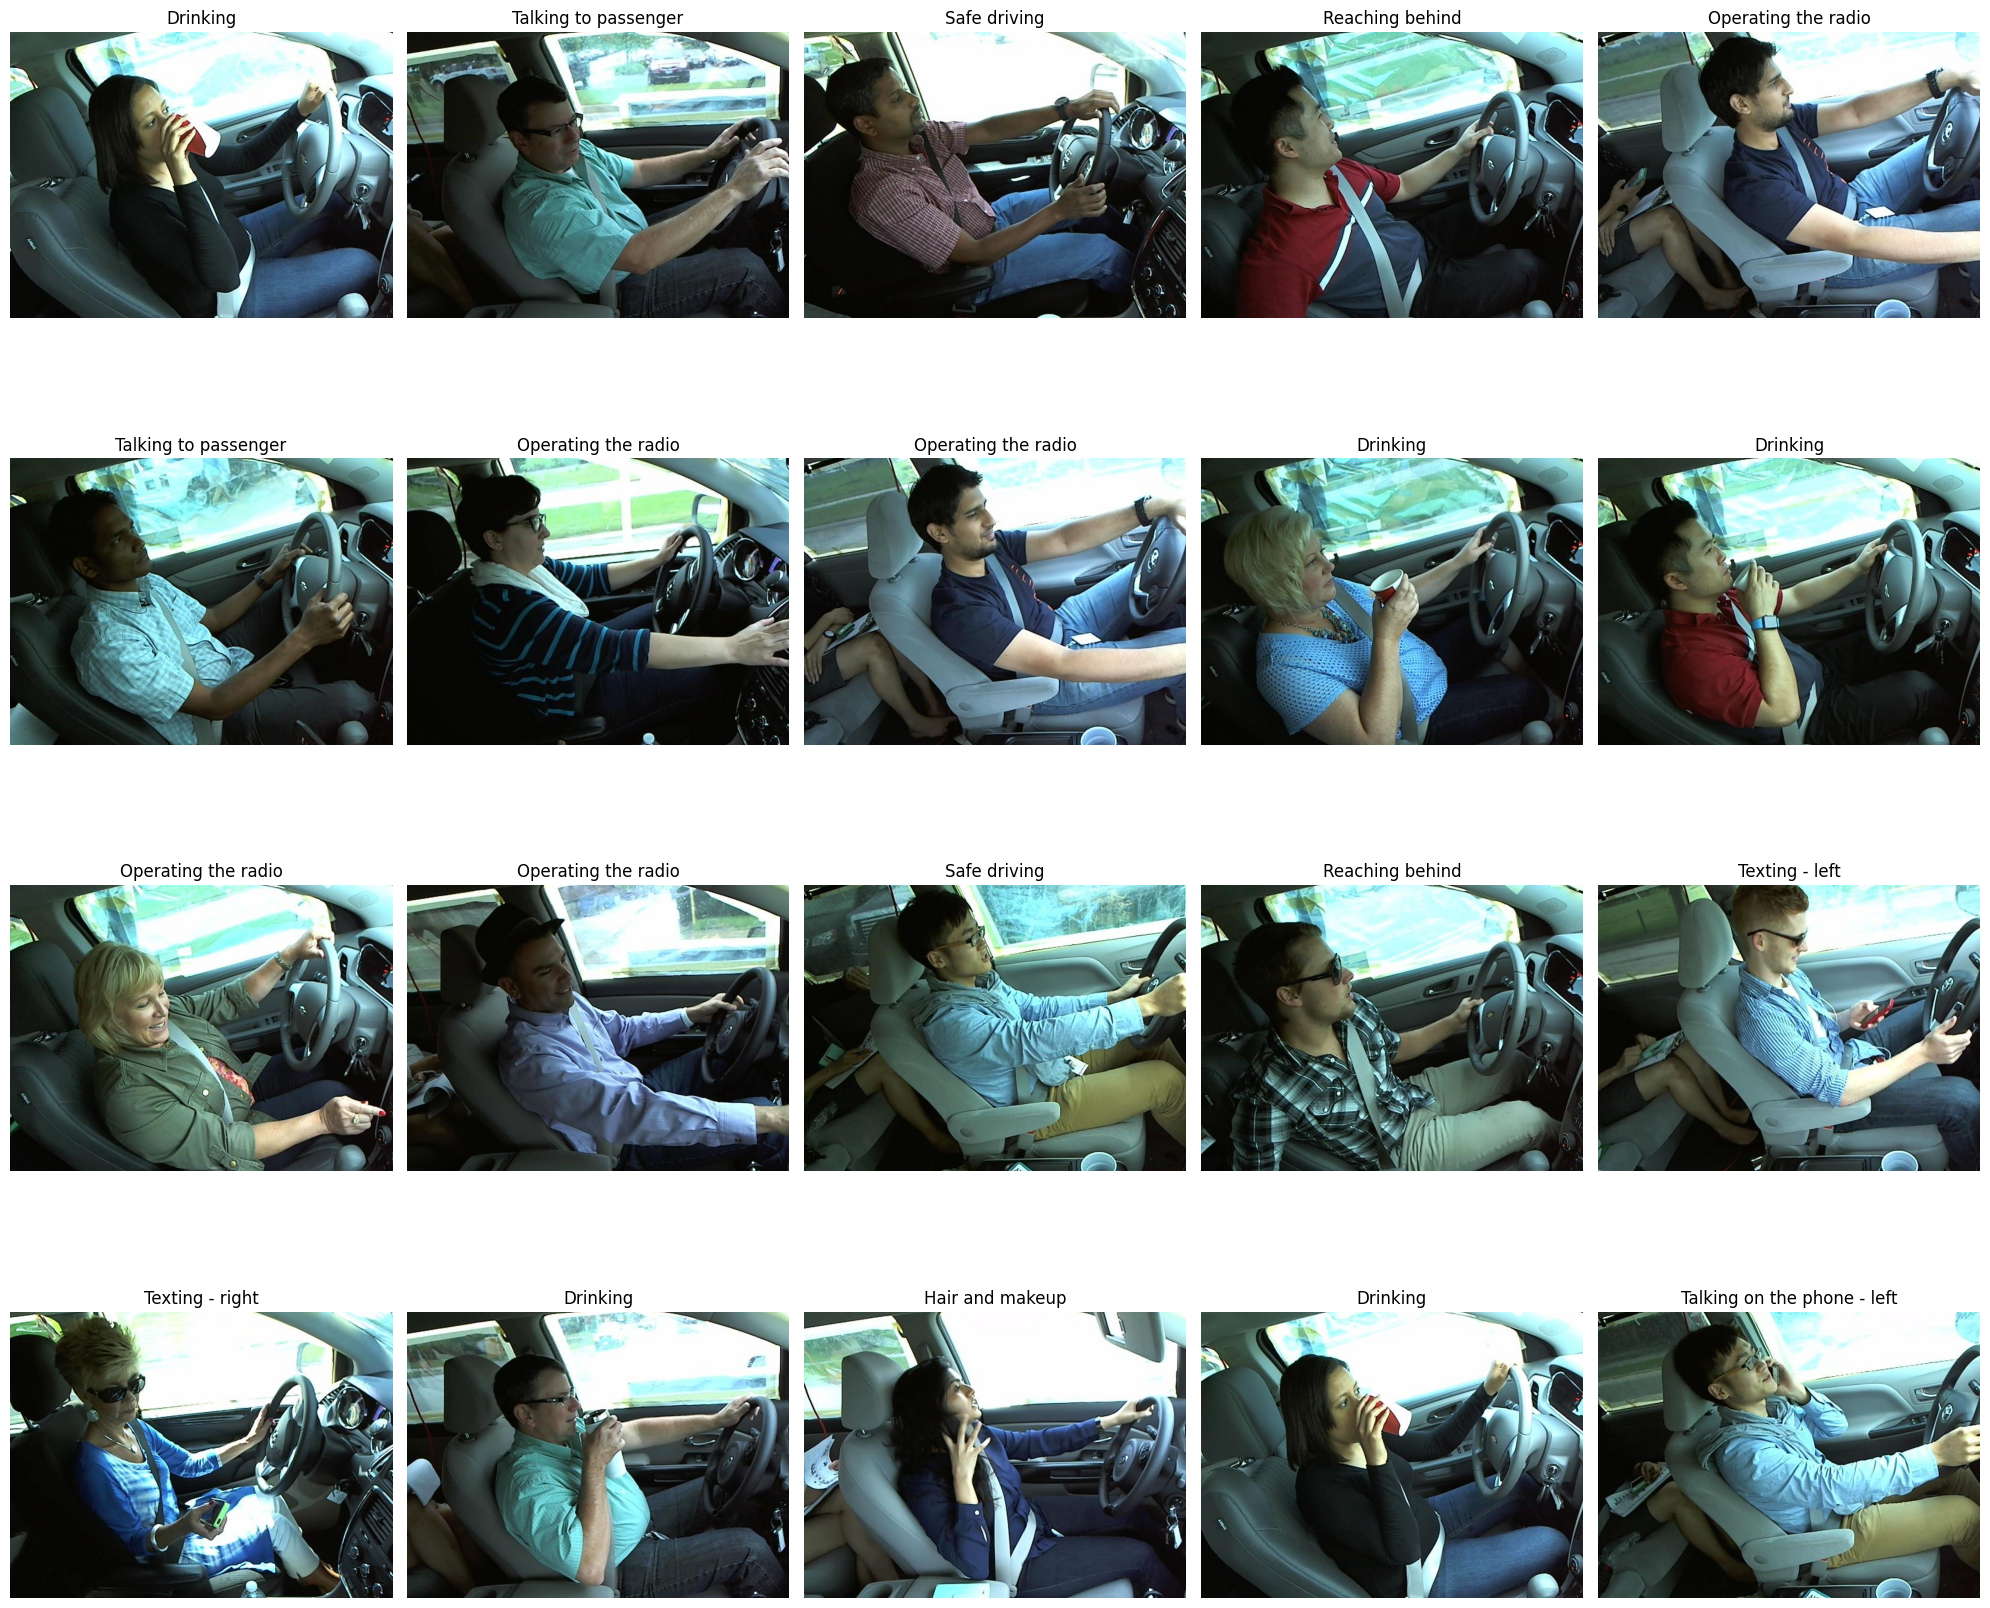

In [ ]:
fig = plt.figure(figsize=(20, 18))
columns = 5
rows = 4
for i in range(1, columns*rows +1):
    pic_idx = random.randint(0, driver_imgs_list.shape[0])
    im = Image.open(os.path.join(train_data,
                                 str(driver_imgs_list.loc[pic_idx, 'classname']),
                                 str(driver_imgs_list.loc[pic_idx, 'img'])))
    fig.add_subplot(rows, columns, i)
    plt.imshow(im)
    
    # Capitalize the first letter of class name
    class_name = classes_names[driver_imgs_list.loc[pic_idx, 'classname']].capitalize()
    
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

# 3. Data Preparation

In [ ]:
# No data augmentation as it reduces accuracy

batch_size = 20

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    train_data,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    train_data,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Getting Data...
Preparing training dataset...
Found 15702 images belonging to 10 classes.
Preparing validation dataset...
Found 6722 images belonging to 10 classes.


# 4. Modelling

In [ ]:
def train_model(model, model_name, train_generator, validation_generator, batch_size, num_epochs=5):
    # Defining callbacks
    checkpoint = ModelCheckpoint(f"{model_name}_best_weights.h5", save_best_only=True)
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(patience=2, factor=0.2)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples // batch_size,
        validation_data = validation_generator, 
        validation_steps = validation_generator.samples // batch_size,
        epochs = num_epochs,
        callbacks=[checkpoint, early_stopping, reduce_lr])
    
    return history

## A. Convolutional Neural Network

In [ ]:
# Define a CNN classifier network

#Dense is the fully connected layer
#Flatten is used after all CNN layers and before fully connected layer
#Conv2D is the 2D convolution layer
#MaxPooling2D is the 2D maxx pooling layer

# Define the model as a sequence of layers
model_complex_cnn = Sequential()

# The input layer accepts an image and applies a convolution that uses 32 6x6 filters and a rectified linear unit activation function
model_complex_cnn.add(Conv2D(32, (6, 6), input_shape=train_generator.image_shape, activation='relu'))

# Next we'll add a max pooling layer with a 2x2 patch
model_complex_cnn.add(MaxPooling2D(pool_size=(2,2)))

# We can add as many layers as we think necessary - here we'll add another convolution layer and another and max poolinglayer
model_complex_cnn.add(Conv2D(32, (6, 6), activation='relu'))
model_complex_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Now we'll flatten the feature maps and generate an output layer with a predicted probability for each class
model_complex_cnn.add(Flatten())
model_complex_cnn.add(Dense(train_generator.num_classes, activation='softmax'))

# We'll use the ADAM optimizer
#other optimizers can also be used for example SGD stochastic gradient descent
complex_cnn_optimizer = tf.optimizers.Adam(learning_rate=0.001)
vgg16_optimizer = RMSprop(learning_rate=0.0001)
mobilenet_optimizer = SGD(learning_rate=0.01)

# With the layers defined, we can now compile the model for categorical (multi-class) classification
model_complex_cnn.compile(loss='categorical_crossentropy',
              optimizer = complex_cnn_optimizer,
              metrics=['accuracy'])

print(model_complex_cnn.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 123, 123, 32)      3488      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 61, 61, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 56, 56, 32)        36896     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 28, 28, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_21 (Flatten)        (None, 25088)             0         
                                                                 
 dense_35 (Dense)            (None, 10)               

In [ ]:
# Train the model over 5 epochs
history_complex_cnn = train_model(
    model=model_complex_cnn,
    model_name="complex_cnn",
    train_generator=train_generator,
    validation_generator=validation_generator,
    batch_size=batch_size
)

Epoch 1/2
 58/785 [=>............................] - ETA: 1:10 - loss: 2.2536 - accuracy: 0.1888

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


785/785 [==============================] - 92s 117ms/step - loss: 0.5119 - accuracy: 0.8332 - val_loss: 0.0933 - val_accuracy: 0.9723 - lr: 0.0010
Epoch 2/2
  1/785 [..............................] - ETA: 1:55 - loss: 0.0094 - accuracy: 1.0000

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


785/785 [==============================] - 92s 118ms/step - loss: 0.0653 - accuracy: 0.9802 - val_loss: 0.0747 - val_accuracy: 0.9774 - lr: 0.0010


## B. Transfer Learning: VGG16

In [ ]:
# Load the VGG16 model without the final output layer
model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=train_generator.image_shape)

# Freeze the layers in the base model
for layer in model_vgg.layers:
    layer.trainable = False

# Add custom layers
x = Flatten()(model_vgg.output)
x = Dense(128, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Define a new model
model_vgg16 = Model(inputs=model_vgg.input, outputs=output)

# We'll use the RMSprop optimizer
vgg16_optimizer = RMSprop(learning_rate=0.0001)

# Compile the model
model_vgg16.compile(optimizer=vgg16_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print(model_vgg16.summary())

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0  

In [ ]:
# Train the model over 5 epochs
history_vgg16 = train_model(
    model=model_vgg16,
    model_name="vgg16",
    train_generator=train_generator,
    validation_generator=validation_generator,
    batch_size=batch_size
)

785/785 [==============================] - 486s 619ms/step - loss: 0.7476 - accuracy: 0.8178 - val_loss: 0.2407 - val_accuracy: 0.9549 - lr: 1.0000e-04


## C. Transfer Learning: EfficientNet

In [ ]:
# Load EfficientNet model without the final output layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Define a new model
model_efficientnet = Model(inputs=base_model.input, outputs=output)

# We'll use the SGD optimizer
efficientnet_optimizer = SGD(learning_rate=0.01)

# Compile the model
model_efficientnet.compile(optimizer=efficientnet_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print(model_efficientnet.summary())

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 rescaling_14 (Rescaling)    (None, 128, 128, 3)          0         ['input_15[0][0]']            
                                                                                                  
 normalization_7 (Normaliza  (None, 128, 128, 3)          7         ['rescaling_14[0][0]']        
 tion)                                                                                            
                                                                                                  
 rescaling_15 (Rescaling)    (None, 128, 128, 3)          0         ['normalization_7[0][0]

In [ ]:
# Train the model over 5 epochs
history_efficientnet = train_model(
    model=model_efficientnet,
    model_name="efficientnet",
    train_generator=train_generator,
    validation_generator=validation_generator,
    batch_size=batch_size
)

785/785 [==============================] - 84s 103ms/step - loss: 2.3048 - accuracy: 0.1078 - val_loss: 2.3005 - val_accuracy: 0.1110 - lr: 0.0100


# 5. Model Evaluation

In [ ]:
def plot_training_history(history, title='Training and Validation Loss & Accuracy'):
    tr_loss = history.history['loss']
    tr_acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(tr_loss) + 1)

    plt.figure(figsize=(18, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(title)
    plt.show()

In [ ]:
def plot_confusion_matrix(model, validation_generator, classes):
    """
    Plot a confusion matrix using validation data.
    
    Args:
    - model : Trained model
    - validation_generator : Validation data generator
    - classes : List of class names
    
    """
    print("Generating predictions from validation data...")
    
    # Get the image and label arrays for the first batch of validation data
    x_test = validation_generator[0][0]
    y_test = validation_generator[0][1]

    # Use the model to predict the class
    class_probabilities = model.predict(x_test)

    # The model returns a probability value for each class
    # The one with the highest probability is the predicted class
    predictions = np.argmax(class_probabilities, axis=1)

    # The actual labels are hot encoded (e.g. [0, 1, 0]), so get the one with the value 1
    true_labels = np.argmax(y_test, axis=1)

    # Plot the confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=85)
    plt.yticks(tick_marks, classes)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

## A. Convolutional Neural Network

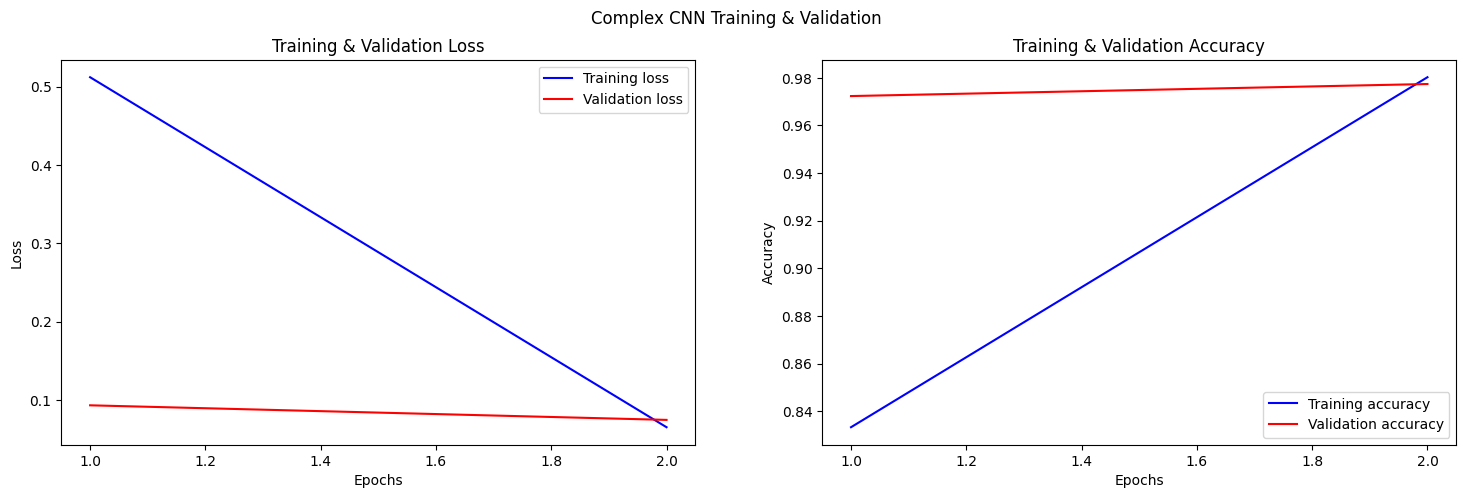

In [ ]:
# Plotting loss and accuracy of training and validation
plot_training_history(history_complex_cnn, title='Complex CNN Training & Validation')

Generating predictions from validation data...
1/1 [==============================] - 0s 60ms/step


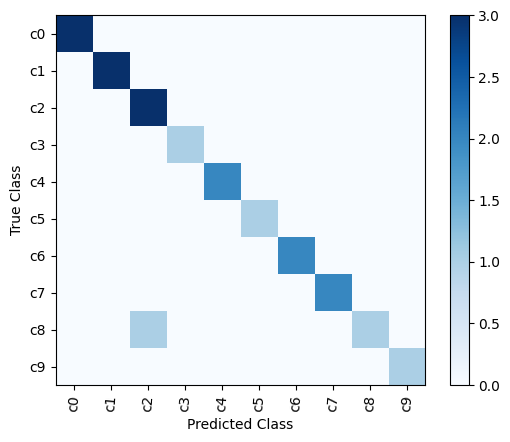

In [ ]:
# Plotting confusion matrix
plot_confusion_matrix(model_complex_cnn, validation_generator, classes)

## B. Transfer Learning: VGG16

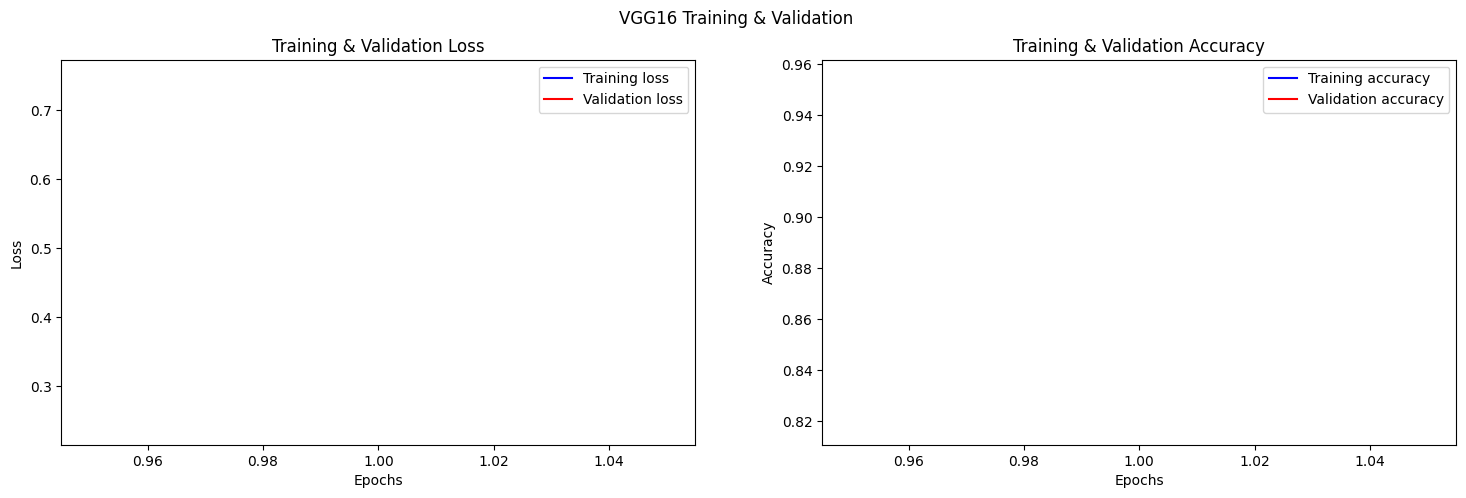

In [ ]:
# Plotting loss and accuracy of training and validation
plot_training_history(history_vgg16, title='VGG16 Training & Validation')

Generating predictions from validation data...
1/1 [==============================] - 1s 563ms/step


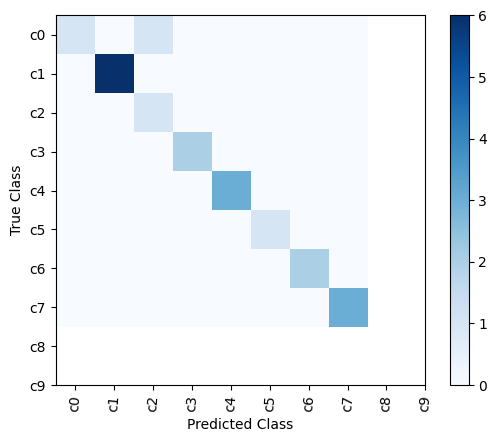

In [ ]:
# Plotting confusion matrix
plot_confusion_matrix(model_vgg16, validation_generator, classes)

## C. Transfer Learning: EfficientNet

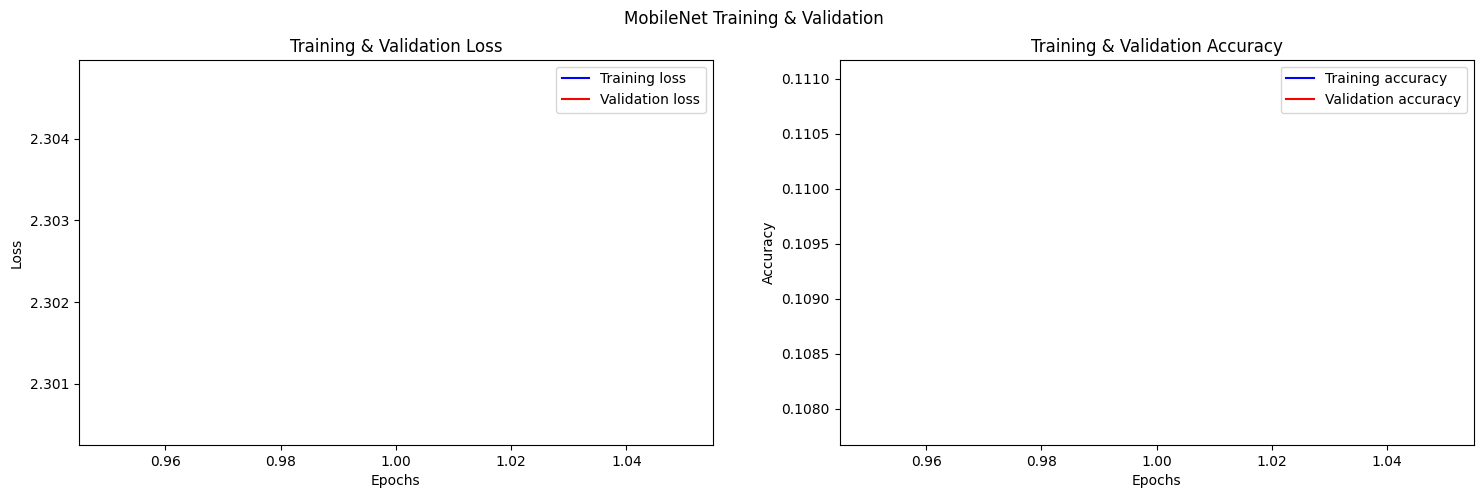

In [ ]:
# Plotting loss and accuracy of training and validation
plot_training_history(history_efficientnet, title='MobileNet Training & Validation')

Generating predictions from validation data...


1/1 [==============================] - 1s 1s/step


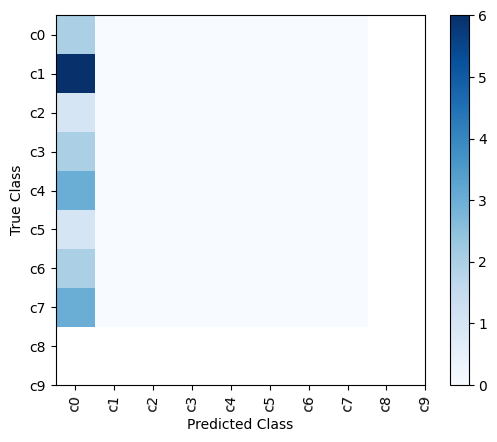

In [ ]:
# Plotting confusion matrix
plot_confusion_matrix(model_efficientnet, validation_generator, classes)

# 6. Model Selection

In [ ]:
def evaluate_and_save_best_model(model_histories, model_names, model_file_name):
    """
    Evaluate models based on validation accuracy and loss, and save the best model to a file.
    
    Args:
    - model_histories: List of history objects of the models
    - model_names: List of model names corresponding to the histories
    - model_file_name: The base file name to save the best model. The model name will be appended.
    
    """
    best_val_accuracy = 0
    best_val_loss = float("inf")
    best_model = None
    best_model_name = None
    
    for history, model_name in zip(model_histories, model_names):
        val_accuracy = history.history['val_accuracy'][-1]
        val_loss = history.history['val_loss'][-1]
        
        # Check if this model has a higher accuracy or lower loss than the current best
        if val_accuracy > best_val_accuracy or (val_accuracy == best_val_accuracy and val_loss < best_val_loss):
            best_val_accuracy = val_accuracy
            best_val_loss = val_loss
            best_model_name = model_name
            
    # Save the best model
    if best_model_name is not None:
        best_model = best_model_name
        best_model.save(f"{model_file_name}_{best_model_name}.keras")
    else:
        print("No model to save.")

In [ ]:
# Saving best model for testing
model_histories = [history_complex_cnn, history_vgg16, history_efficientnet]
models = [model_complex_cnn, model_vgg16, model_efficientnet]
model_names = ["CNN", "VGG16", "MobileNet"]

model_evaluation(
    model_histories=model_histories,
    models=models,
    model_names=model_names,
    model_file_name="best_model"
)

# 7. Model Deployment

In [ ]:
# Helper function to resize image
def resize_image(src_img, size=(128,128), bg_color="white"): 
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new image of the right shape
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))
  
    # return the resized image
    return new_image

# Function to predict the class of an image
def predict_image(classifier, image_array):
    import numpy as np
    
    # We need to format the input to match the training data
    # The data generator loaded the values as floating point numbers
    # and normalized the pixel values, so...
    img_features = image_array.astype('float32')
    img_features /= 255
    
    # Predict the class of each input image
    predictions = classifier.predict(img_features)
    
    predicted_classes = []
    for prediction in predictions:
        # The prediction for each image is the probability for each class, e.g. [0.8, 0.1, 0.2]
        # So get the index of the highest probability
        class_idx = np.argmax(prediction)
        # And append the corresponding class name to the results
        predicted_classes.append(classes_names[int(class_idx)])
    # Return the predictions
    return predicted_classes

print("Functions created - ready to use model for inference.")

Functions created - ready to use model for inference.


In [ ]:
%matplotlib inline

# load the saved model
modelFileName = 'shape-classifier.h5'
model_complex_cnn = load_model(modelFileName) 

# get the list of test image files
test_image_files = os.listdir(test_data)

# Empty array on which to store the images
image_arrays = []

size = (128,128)
background_color="white"

fig = plt.figure(figsize=(12, 8))

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_data, test_image_files[file_idx]))
    
    # resize the image so it matches the training set - it must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size, background_color))
    
    # Add the image to the array of images
    image_arrays.append(resized_img)

# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(model_complex_cnn, np.array(image_arrays))

# plot easch image with its corresponding prediction
for idx in range(len(predictions)):
    a=fig.add_subplot(1,len(predictions),idx+1)
    imgplot = plt.imshow(image_arrays[idx])
    a.set_title(predictions[idx])

/var/folders/5f/06bzwqjd1kl3lkb5zlxrzcp00000gn/T/ipykernel_27308/3679634320.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  src_img.thumbnail(size, Image.ANTIALIAS)


 158/2492 [>.............................] - ETA: 1:38

: 

: 